<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Équilibres chimiques
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Composition à l'équilibre | Réactions équilibrées et quantitatives
             </div>
        </div>
    </div>
</div>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib inline

# import des librairies 
import numpy as np
from scipy.optimize import bisect, newton
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique
##  Exemple de réaction d'oxydo-réduction quantitative en phase aqueuse
On considère le système réactionnel isochore dans lequel on place une solution aqueuse de diiode $\text{I}_{2\text{(aq)}}$ de concentration initiale $C_0$, ainsi qu'une solution aqueuse de thiosufate de sodium ($\text{S}_2\text{O}^{2-}_{3\text{(aq)}} + \text{Na}^+$) de concentration initiale $C_1$. La réaction entre ces deux espèces rédox répond à l'équation de réaction :
$$\text{I}_{2\text{(aq)}} + 2 \text{S}_2\text{O}^{2-}_{3\text{(aq)}} \to 2\text{I}^- + \text{S}_4\text{O}^{2-}_{6\text{(aq)}} $$

&nbsp;
Cette réaction est quantitative et répond au tableau d'avancement ci-dessous :

|$\text{mole.L}^{-1}$|$\text{I}_{2\text{(aq)}}$|$+ 2 \text{S}_2\text{O}^{2-}_{3\text{(aq)}}$|$\to 2\text{I}^-$|$+ \text{S}_4\text{O}^{2-}_{6\text{(aq)}}$|
|:-----------|:-------:|:--------:|:----:|:---:|
|$\text{E.I.}$| $C_0$   | $C_1$    | $0$  | $0$ |
|$\forall t$ | $C_0-x$ | $C_1-2x$ | $2x$ | $x$ |

&nbsp;
La réaction étant quantitative, il suffit de chercher le réactif limitant pour établir la valeur de l'avancement à l'équilibre.

## Mise en œuvre numérique

Pour plus de généralités on crée deux listes 
* une liste `coef` contenant les coefficients stœchiométriques algébriques des espèces de la réaction étudiée ;
* une liste `conc_init` contenant les concentrations initiales des diverses espèces de la réaction étudiée.

On peut alors facilement en déduire l'expression de la concentration à tout instant que l'on stocke dans une nouvelle liste notée `conc_t`.

&nbsp;
La méthode `root` (voir https://numpy.org/doc/stable/reference/generated/numpy.roots.html)de numpy permet de trouver rapidement les racines d'un polynôme d'ordre quelconque et donc d'en déduire le réactif limitant.

In [2]:
# concentrations des réactifs
C0 = 1e-2
C1 = 1e-2
# coefficients stœchiométriques algébriques
coef = [-1, -2, 2, 1]
# concentrations initiales
conc_init = [C0, C1, 0, 0]

# concentration à un instant quelconque, écrite sous forme de polynôme du 1e degré
conc_t=[]
for i in range(len(coef)) :
    conc_t.append([coef[i], conc_init[i]])

sol=[]
for i in range(len(conc_t)):
    if coef[i] < 0 : # on ne traite que les réactifs, de coefficients stœchiométriques algébriques négatifs
        sol.append(np.roots(conc_t[i]))

# le réactif limitant est celui qui est consommé pour l'avancement le plus faible
x_vol=min(sol)
# on cherche le, ou les indices qui correspondent au réactif limitant
indices = [i for i, x in enumerate(sol) if x == min(sol)]

# on affiche les résultats
print("La valeur de l'avancement volumique maximal est : %.3f mol/L" % x_vol[0])
print("Il correspond à l'(aux)espèce(s) d'indice(s) : ", indices)
ta_max=[conc_init[i]+coef[i]*x_vol[0] for i in range(len(coef))]
print("Le tableau d'avancement, à l'avancement volumique maximal vaut : ", ta_max,"mol/L")

La valeur de l'avancement volumique maximal est : 0.005 mol/L
Il correspond à l'(aux)espèce(s) d'indice(s) :  [1]
Le tableau d'avancement, à l'avancement volumique maximal vaut :  [0.005, 0.0, 0.01, 0.005] mol/L


##  Exemple de réaction équilibrée : synthèse gazeuse du dibrome
Un récipient de volume $V_0 = 2,00~\text{L}$ contient initialement $n_0 = 0,500~\text{mol}$ de $\text{COBr}_{2\text{(g)}}$, dans lequel on place également $n_1 = 0,100~\text{mol}$ de $\text{CO}_\text{(g)}$ et $n_2 = 0,200~\text{mol}$ de $\text{Br}_{2\text{(g)}}$.<br/>
Le $\text{COBr}_{2\text{(g)}}$ se décompose à une température de $346~\text{K}$ selon l’équation de réaction : $$\text{COBr}_{2\text{(g)}} \to \text{CO}_\text{(g)} + \text{Br}_{2\text{(g)}}$$

&nbsp;
Tous les gaz sont supposés parfaits et la constante d’équilibre à $346~\text{K}$ est : $K^\circ = 5,46$.

&nbsp;
Cette réaction est équilibrée et répond au tableau d'avancement suivant :

|$\text{mol}$|$\text{COBr}_{2\text{(g)}}$|$\to \text{CO}_\text{(g)}$|$+ \text{Br}_{2\text{(g)}}$|$n_\text{tot}^\text{gaz}$|
|:------------|:-------:|:-------:|:-------:|:------------:|
|$\text{E.I.}$|$n_0$    |$n_1$    |$n_2$    |$n_0+n_1+n_2$    |
|$\forall t$  |$n_0-\xi$|$n_1+\xi$|$n_2+\xi$|$n_0+n_1+n_2+\xi$|

&nbsp;
La réaction est équilibrée, et l'avancement réactionnel l'équilibre correspond à l'égalité du quotient réactionnel et de la constante d'équilibre. Compte-tenu de la nature gazeuse des réactifs, l'activité $a_i$ d'une espèce gazeuse est : 
$$a_i=\dfrac{P_i}{P^\circ}=n_i\dfrac{RT}{VP^\circ}$$

&nbsp;
À l'équilibre, on a donc l'égalité : 
$$K^\circ = \dfrac{\frac{(n_1+\xi)RT}{P^\circ V}\frac{(n_2+\xi)RT}{P^\circ V}}{\frac{(n_0-\xi)RT}{P^\circ V}}=\dfrac{(n_1+\xi)(n_2+\xi)}{(n_0-\xi)}\dfrac{RT}{P^\circ V}$$

## Mise en œuvre numérique

Comme précédemment, on crée deux listes :
* une liste `coef` contenant les coefficients stœchiométriques algébriques des espèces de la réaction étudiée ;
* une liste `conc_init` contenant les concentrations initiales des diverses espèces de la réaction étudiée.

Connaissant $\xi$, on peut alors en déduire l'expression de la concentration à tout instant que l'on stocke dans une nouvelle liste notée `conc_t`.

&nbsp;
La méthode de dichotomie `bisect` (voir <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html"> doc. </a>) et la méthode de Newton `newton` (voir <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html"> doc. </a>), toutes deux issues de la librairie `scipy`permettent de trouver une racine d'une fonction $f$ quelconque dans un intervalle $[a,b]$ ou à partir d'une valeur proche.

&nbsp;
L'intervalle de recherche à donner pour  `bisect` est celui compris entre les valeurs extrêmes possibles de $\xi$ : $\xi_\text{max}=0,5~\text{mol}$ (exclut de la recherche car donne $Q\to +\infty$) et $\xi_\text{min}=-0,1~\text{mol}$ (réaction quantitative en sens indirect).

&nbsp;
Compte-tenu de la faible valeur de $K^\circ$, on peut supposer que la réaction ne sera pas quantitative, et donner à la méthode `newton` une valeur initiale faible, ici $\xi=0,1~\text{mol}$.

&nbsp;
Il ne reste qu'à coder une fonction qui s'annule pour la concentration à l'équilibre, la fonction : $\xi \mapsto Q(\xi)-K^\circ$ que l'on code sous le nom `solve`.

In [3]:
# quantités de matière initiales
n0 = 0.5
n1 = 0.1
n2 = 0.2
# coefficients stœchiométriques algébriques
coef = [-1, 1, 1]
# quantités de matière initiales
n_init = [n0, n1, n2]

# constante d'équilibre
K0 = 5.46
# données thermodynamiquse
P0 = 1.0e5
T = 346
V = 2.0e-3
R = 8.314

# fonction qui s'annule lorsque xi=xi_eq
def solve(xi):
    return R*T*(n1+xi)*(n2+xi)/((n0-xi)*P0*V)-K0

# appel des diverses fonctions de recherche de racines
xi_eq=bisect(solve, -.1, .499) # on donne la fonction et l'intervalle initiale de recherche tel que f(a)*f(b)<0
xi_eq2=newton(solve, 0.1) # on donne une valeur initiale faible

print("La valeur de l'avancement à l'équilibre, calculé par la méthode de dichotomie vaut : %.5f mol" % xi_eq)
print("La valeur de l'avancement à l'équilibre, calculé par la méthode de Newton vaut : %.5f mol" % xi_eq2)

ta_max=[round(n_init[i]+coef[i]*xi_eq,6) for i in range(len(coef))]
print("Le tableau d'avancement, à l'avancement d'équilibre vaut : ", ta_max,"mol")

La valeur de l'avancement à l'équilibre, calculé par la méthode de dichotomie vaut : 0.19430 mol
La valeur de l'avancement à l'équilibre, calculé par la méthode de Newton vaut : 0.19430 mol
Le tableau d'avancement, à l'avancement d'équilibre vaut :  [0.305696, 0.294304, 0.394304] mol


On peut également tracer l'ensemble des valeurs possibles pour le quotient réactionnel et comparer cette valeur à la constante d'équilibre. On constate que l'égalité $Q_r=K^\circ$ est bien réalisée pour la valeur trouvée à l'étape précédente.

&nbsp;
*NB : le tracé est tronqué pour des valeurs de $\xi$ comprise entre $0$ et $\frac{n_0}{2}$ pour conserver une certaine lisibilité à ce diagramme.*

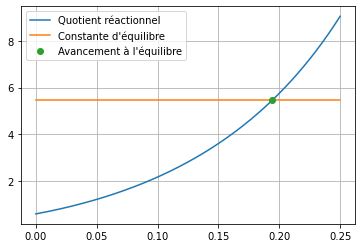

In [4]:
plt.figure()
N=1000
xi=np.linspace(0,n0/2, N)
def Q(xi):
    return R*T*(n1+xi)*(n2+xi)/((n0-xi)*P0*V)
plt.plot(xi, Q(xi), label="Quotient réactionnel")
plt.plot([xi[0],xi[N-1]],[K0,K0], label="Constante d'équilibre")
plt.plot(xi_eq,Q(xi_eq),'o', label="Avancement à l'équilibre")
plt.grid(True)
plt.legend()
plt.show()